In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
import cv2

In [0]:
!ls

In [0]:
def abrir_imagem(img_caminho):
    """
        img_caminho: caminho completo para a imagem
    """
    imagem = cv2.imread(img_caminho, cv2.IMREAD_GRAYSCALE)

    if imagem is None:
        raise NameError("O OpenCV não conseguiu abrir sua imagem. Verique o caminho.")

    return imagem

In [0]:
caminho_absoluto = lambda img_nome:"My Drive/Curso-OMR/images-test/"+img_nome
nome_imagem = "teste1.png"
imagem = abrir_imagem(caminho_absoluto(nome_imagem))

In [0]:
_, img_binarizada = cv2.threshold(imagem, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

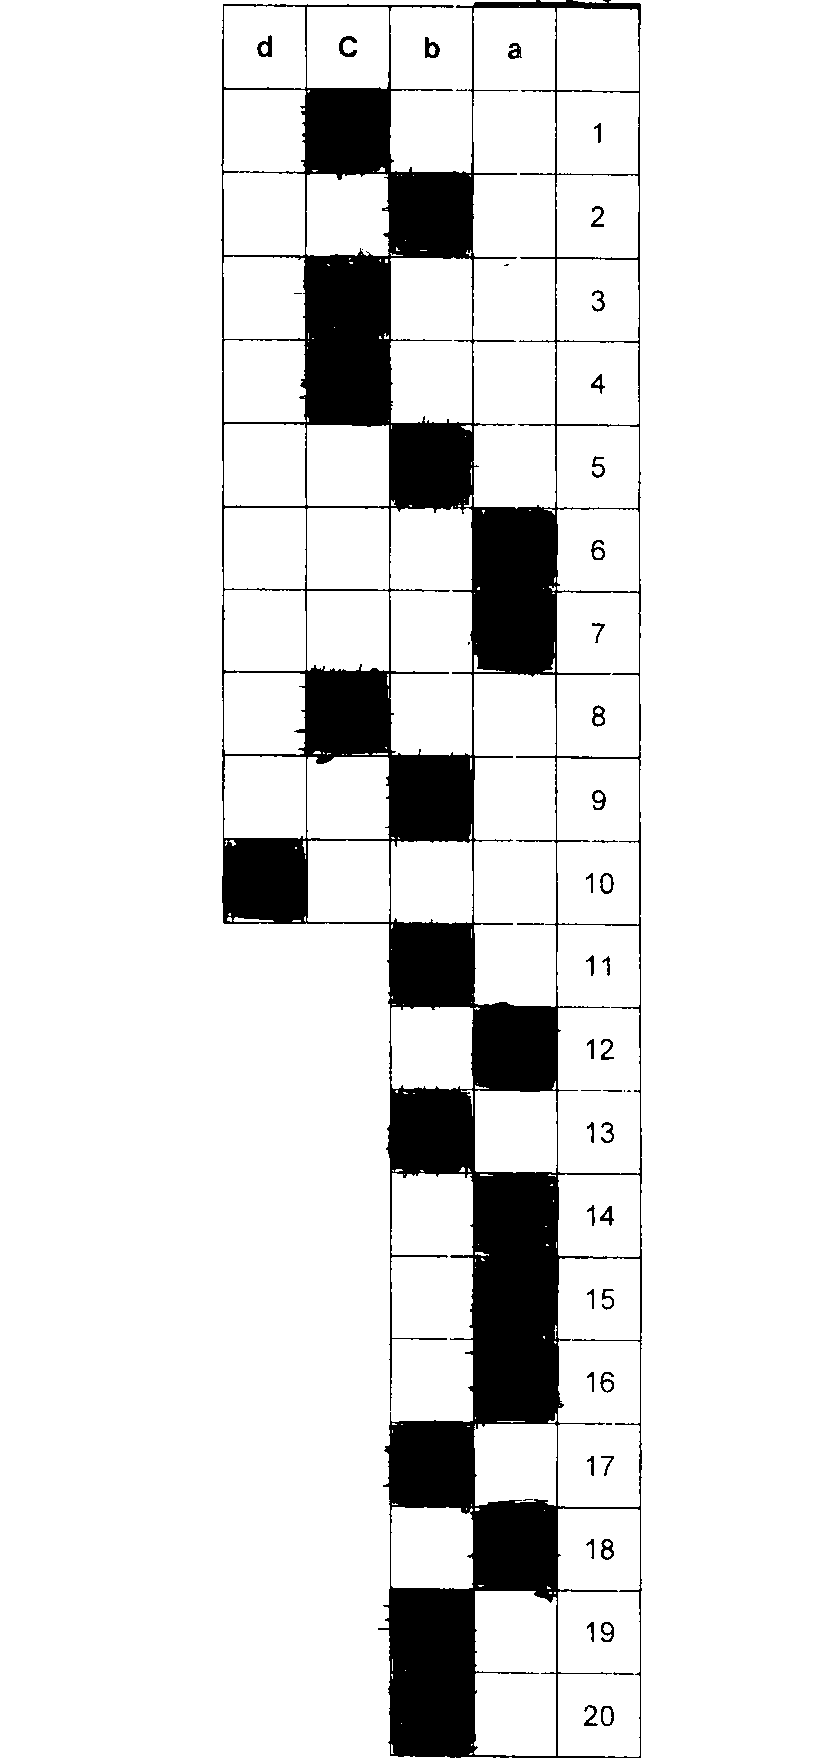

In [0]:
from google.colab.patches import cv2_imshow

cv2_imshow(img_binarizada)

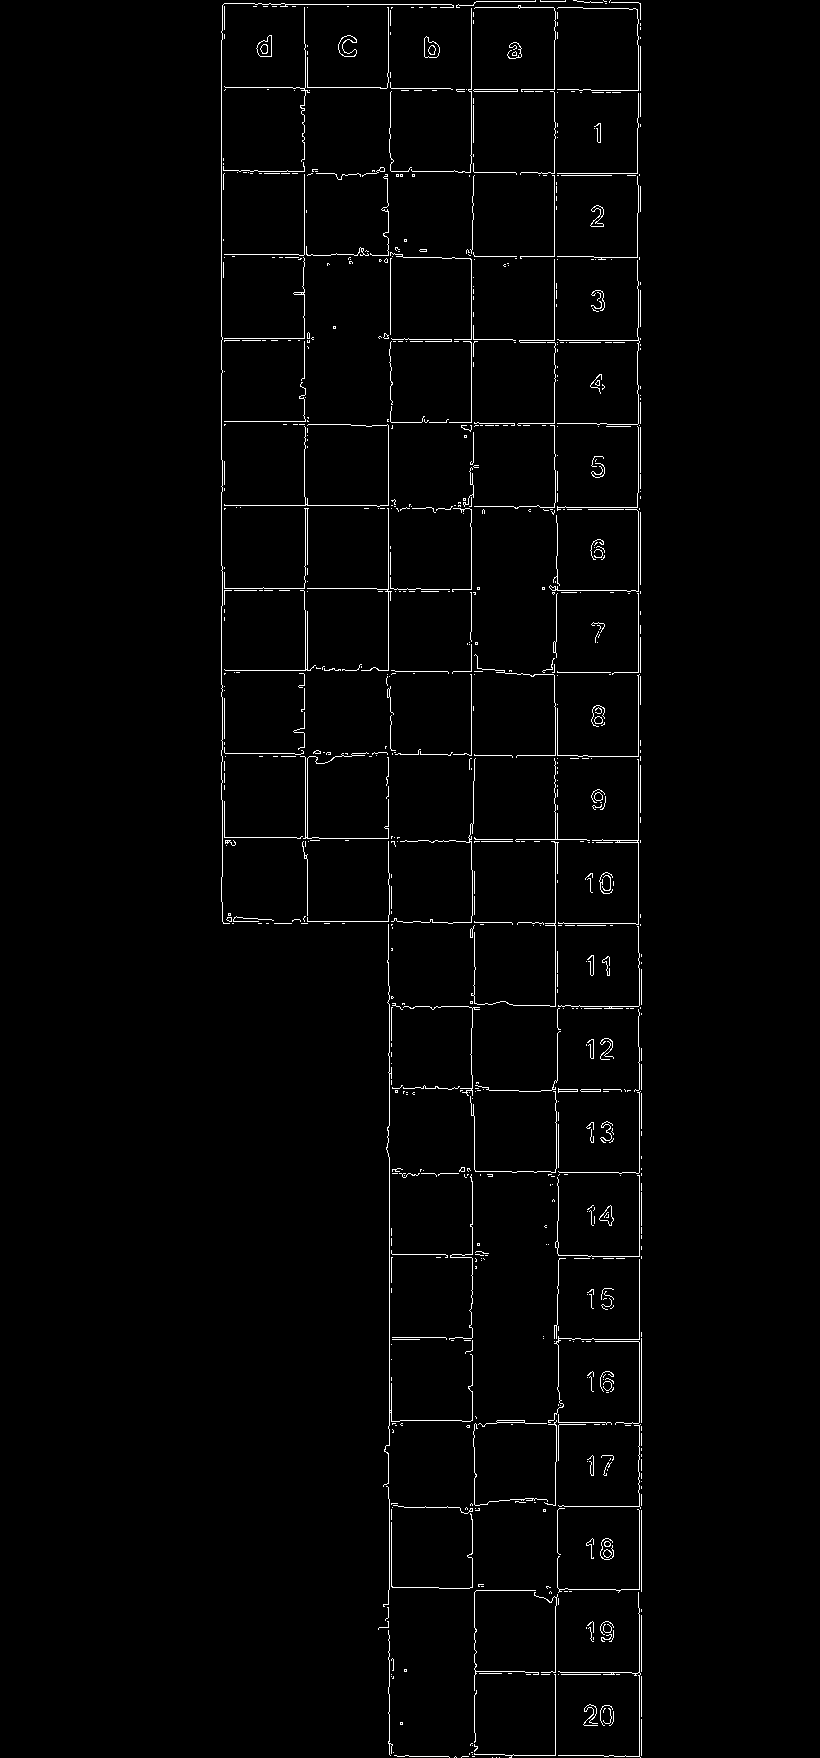

In [0]:
canny = cv2.Canny(img_binarizada, 100, 200)
cv2_imshow(canny)